In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
import math
from sklearn.preprocessing import OneHotEncoder
import numpy as np

c:\Users\user\anaconda3\envs\summarizerP39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_res = 32
zoom_factor = 1

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(image_res * 2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 3)
        
        #nn.init.uniform_(self.fc1.weight, a=-1, b=1)
        #nn.init.uniform_(self.fc2.weight, a=-1, b=1)
        #nn.init.uniform_(self.fc3.weight, a=-1, b=1)
        #nn.init.uniform_(self.fc4.weight, a=-1, b=1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        
        return x

net = Net()
GPU = torch.device("cuda")
net.to(GPU)

Net(
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=3, bias=True)
)

In [4]:
loss = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [5]:
def fast_onehot(values):
    encoded = F.one_hot(values)
    encoded = torch.reshape(encoded, (image_res, image_res, -1))
    
    return encoded.to(torch.float32)

In [6]:
def training_only_onehot(value, total):
    encoded = torch.zeros(total)
    encoded[value] = 1
    return encoded

In [7]:
def get_img_array():
    coords = torch.meshgrid(torch.arange(image_res, dtype=torch.long, device=GPU),
                            torch.arange(image_res, dtype=torch.long, device=GPU))
    
    coords = torch.stack(coords, dim=-1)
    
    coords = fast_onehot(coords)
    
    image = net(coords)
    return image

In [8]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")
    img_array = np.array(img) / 255

    return img_array

In [9]:
def display_image(img_array):
    if type(img_array) != type(np.array([1, 2, 3])):
        img_array = img_array.detach().cpu().numpy()
    plt.imshow(img_array)
    plt.show()

In [10]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    loss = loss(outputs, answer_tensor)
    loss.backward()
    optimizer.step()

In [11]:
# TRAINING:

In [12]:
files = os.listdir(r"C:\Users\user\Desktop\learning from human\images")

questions = []
answers = []

for image in tqdm(files):
    img = load_image(fr"C:\Users\user\Desktop\learning from human\images\{image}")
    
    for x in range(len(img)):
        for y in range(len(img[x])):
            questions.append(torch.cat((training_only_onehot(x, image_res), training_only_onehot(y, image_res))).to(GPU))
            answers.append(torch.tensor(img[x][y]).to(GPU).to(torch.float32))

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
for x in tqdm(range(len(questions))):
    train_nn(questions[x], answers[x], net)

100%|██████████| 10240/10240 [00:13<00:00, 733.87it/s]


c:\Users\user\anaconda3\envs\summarizerP39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


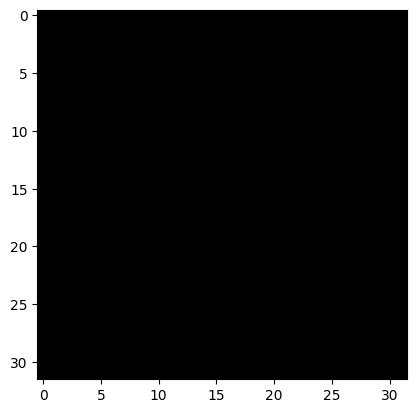

In [14]:
display_image(get_img_array())